# Real Estate Price Estimation
Given the fact that a majority of the CMU graduates are landing in the Bay Area in the following years, we are interested in finding out the future prices of the real estates.

When we are looking for a real estate, we usually want to know the safety and life convenience around the area. Besides, the distance to the companies and the schools are also factors for consideration.

Based on our interests, we think of a data science pipeline as following.

### Data Science Pipeline

0. Data Scraping
    - Housing: Onboard Informatics API
    - Crime: Government Data
    - Education: Google Place API
    - Company: Google Place API
    - Lifestyle: Yelp API
1. Data Processing
    - Join places of interests onto each data point
2. Data Exploration
    - Distribution of categorical/discrete numeric data
    - Distribution of continuous numeric data
    - Data cleaning
3. Feature Engineering
    - Remove some irrelevant fields
    - Calculate weighted distance from places of interests
    - Map categorical variables and normalize the numeric data
4. Machine Learning Models
    - Linear regression with Lasso regularizer
    - Polynomial regression
    - Random forests regressor
    - Model Selection: Grid Search CV

## 1. Data Scraping
In this part, we requested several APIs for the data we need and tranformed them into csv format. We will give an example on company data.

In [4]:
import json
import requests
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from scipy.special import boxcox1p
from sklearn.model_selection import learning_curve
from sklearn import preprocessing
from urllib.request import urlopen
from scipy.spatial.distance import cdist

import math
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [12]:
def get_companies():
    company_list = []  # name, place

    with open('Internet_Company','r',encoding='utf8') as f:
        for line in f.readlines():
            line = line.strip('\n')
            line = line.split('–')
            name = line[0].strip().replace(' ','_')
            place = line[1].strip().replace(' ','_')
            query = 'https://maps.googleapis.com/maps/api/place/textsearch/json?query={}+in+{}&key={}'.format(name, place, api_key)
            response = requests.get(query)
            result = response.json()
            outputFile = 'pdsData/day2/'+name+'.json' # output file location
            with open(outputFile,'w') as write_file:
                json.dump(result,write_file)

get_companies()

In [13]:
def read_companies_json():
    path = 'pdsData/day2/' # read json files we just generated above
    companies_list = []
    for filename in os.listdir(path):
        with open(path+filename, 'r') as read_file:
            data=json.load(read_file)
            try:
                name=data['results'][0]['name']
                lat=data['results'][0]['geometry']['location']['lat']
                lon=data['results'][0]['geometry']['location']['lng']
                companies_list.append((name,lat,lon))
            except:
                continue
    return companies_list


In [ ]:
# write to csv file
def write_companies_to_csv(companies_list):
"""
input: companies_list (list): list of tuples (company_name, lat, lon)
"""
    outputFile = 'tech_companies.csv'
    with open(outputFile, 'w',newline='') as f:
        writer = csv.writer(f,delimiter=',')
        writer.writerow(('Company','lat','lon'))
        writer.writerows(companies_list)

## 2. Data Processing

In the following part, we join below four tables using zip code.

**House data:** `cleaned_data.csv`

**School data:** `zip_num_school.csv`

**Crime data:** `zip_num_crime.csv`

**Company data:** `company_weighted_dist.csv`

### 2.1 Housing data

In [18]:
# read data of houses
houses = pd.read_csv('cleaned_data.csv').drop('Unnamed: 0', axis=1)
houses.head()

,bathstotal,beds,latitude,longitude,zipcode,propclass,saleTransDate,saleamt,universalsize,yearbuilt,age_year,price,duplex,Apartment,condo,townhouse
0,0.0,0,37.804640,-122.405206,94111,Condominium (residential),2016-01-04,970000,1299,1993,23,746.728253,0,0,1,0
1,3.0,2,37.780431,-122.389276,94107,Condominium (residential),2016-01-04,1370000,1348,2000,16,1016.320475,0,0,1,0
2,2.0,0,37.798254,-122.417974,94109,Single Family Residence / Townhouse,2016-01-04,1710000,562,1949,67,3042.704626,0,0,0,1
3,7.0,6,37.774411,-122.426291,94102,"""Duplex, Triplex, Quadplex)""",2016-01-04,2625000,3634,1900,116,722.344524,1,0,0,0
4,1.0,2,37.778018,-122.507005,94121,Single Family Residence / Townhouse,2016-01-05,665000,660,1916,100,1007.575758,0,0,0,1


In [20]:
print("number of records:", len(houses))

number of records: 4574


In [21]:
# Check missing value of house data
houses.isnull().sum()

bathstotal       0
beds             0
latitude         0
longitude        0
zipcode          0
propclass        0
saleTransDate    0
saleamt          0
universalsize    0
yearbuilt        0
age_year         0
price            0
duplex           0
Apartment        0
condo            0
townhouse        0
dtype: int64

### 2.2 School data
We counted the number of schools within a zipcode district and then join it to each house.

In [22]:
school_df = pd.read_excel('School_Directory.xlsx')

In [23]:
school_df = school_df[['School', 'Entity Type', 'Public Yes/No', 'Street Address', 'Street City', 'Street Zip']].dropna(axis=0, how='any')
school_df.isnull().sum()

School            0
Entity Type       0
Public Yes/No     0
Street Address    0
Street City       0
Street Zip        0
dtype: int64

In [34]:
# get all schools in SF
sf_school_df = school_df[school_df['Street City'].str.startswith('San Fra')]
sf_school_df['Street City'] = 'San Francisco'
sf_school_df['Street Zip'] = sf_school_df['Street Zip'].apply(lambda x: x.split("-")[0])
sf_school_df.head()

,School,Entity Type,Public Yes/No,Street Address,Street City,Street Zip
2952,Osagie International Academy Charter,K-12 Schools (Public),Y,388 Market St.,San Francisco,94111
12127,Swiss American Academy,High Schools (Private),N,"101 California St. Ste. 2710 San Fransisco, CA",San Francisco,94530
18071,Adams (John) Adult High,Adult Education Centers,Y,1860 Hayes St.,San Francisco,94117
18072,Alemany Adult,Adult Education Centers,Y,750 Eddy St.,San Francisco,94109
18073,Galileo Adult High School,Adult Education Centers,Y,2112 Greenwich St.,San Francisco,94123


In [25]:
sf_school_df['Street Zip'].unique()

array(['94111', '94530', '94117', '94109', '94123', '94114', '94102',
       '94124', '94132', '94115', '94116', '94103', '94127', '94110',
       '94121', '94131', '94134', '94107', '94112', '94122', '94108',
       '94118', '94133', '94129', '94135', '94130', '94105', '94126'], dtype=object)

In [26]:
# #schools for each zip code
zip_to_num_schls = {}
for name, group in sf_school_df.groupby('Street Zip'):
    zip_to_num_schls[name] = len(group)

In [31]:
# generate a dataframe: ['zip_code', 'num_schools']
zip_school_df = pd.DataFrame({'zip_code': list(zip_to_num_schls.keys()), 'num_schools': list(zip_to_num_schls.values())},
                            columns=['zip_code', 'num_schools'])
zip_school_df.head()

,zip_code,num_schools
0,94102,17
1,94103,10
2,94105,3
3,94107,16
4,94108,6


In [32]:
zip_school_df.to_csv('zip_num_school.csv', index=False)

In [33]:
# read data of schools_zip
schools = pd.read_csv('zip_num_school.csv')

In [35]:
crime_df = pd.read_csv('SF_Crime_ByDistrict_2017.csv')
crime_df = crime_df[['Category', 'PdDistrict', 'Address', 'X', 'Y']]
crime_df.head()

,Category,PdDistrict,Address,X,Y
0,LARCENY/THEFT,NORTHERN,0 Block of HERMANN ST,-122.425963,37.770708
1,LARCENY/THEFT,NORTHERN,0 Block of HERMANN ST,-122.425963,37.770708
2,LARCENY/THEFT,NORTHERN,HAIGHT ST / STEINER ST,-122.432096,37.771896
3,"SEX OFFENSES, FORCIBLE",INGLESIDE,100 Block of DUNCAN ST,-122.423484,37.746362
4,TRESPASS,TENDERLOIN,200 Block of TURK ST,-122.413238,37.782843


### 2.3 Crime Data
We counted the number of crims commited within a zipcode district and then join it to each house.

In [36]:
crime_df['PdDistrict'].unique()

array(['NORTHERN', 'INGLESIDE', 'TENDERLOIN', 'PARK', 'TARAVAL',
       'SOUTHERN', 'MISSION', 'CENTRAL', 'BAYVIEW', 'RICHMOND'], dtype=object)

Allocate zip codes to districts, source: http://www.healthysf.org/bdi/outcomes/zipmap.htm  
'TARAVAL' is included in 'PARK'.

<img src="http://www.healthysf.org/bdi/outcomes/images/zip-map.jpg">

In [37]:
district_to_zip = {'NORTHERN': [94115, 94123,  94108, 94109, 94133, 94104, 94105, 94106, 94111],
                  'INGLESIDE':[94112],
                  'TENDERLOIN':[94102],
                  'PARK_TARAVAL':[94116],
                  'SOUTHERN': [94132, 94127, 94134],
                  'MISSION':[94110],
                  'CENTRAL':[94117, 94114, 94131, 94103],
                  'BAYVIEW':[94124],
                  'RICHMOND':[94118, 94121],
                  'SUNSET':[94122],
                  'POTRERO HILL':[94107]}

In [38]:
district_to_num_crimes = {'PARK_TARAVAL': 0}
# PARK and TARAVAL are merged to one category
for name, group in crime_df.groupby('PdDistrict'):
    if name == 'PARK' or name == 'TARAVAL':
        district_to_num_crimes['PARK_TARAVAL'] += len(group)
    district_to_num_crimes[name] = len(group)

district_crime_df = pd.DataFrame({'district': list(district_to_num_crimes.keys()), 'num_crimes': list(district_to_num_crimes.values())},
                            columns=['district', 'num_crimes'])
district_crime_df
# PARK_TARAVAL: 121368575 + 12136

,district,num_crimes
0,PARK_TARAVAL,20711
1,BAYVIEW,13994
2,CENTRAL,18993
3,INGLESIDE,11515
4,MISSION,21788
5,NORTHERN,21040
6,PARK,8575
7,RICHMOND,9478
8,SOUTHERN,28424
9,TARAVAL,12136


In [39]:
district_crime_df.to_csv('district_num_crime.csv', index=False)

Create a csv: zip_code, district, num_crimes

In [40]:
#zip_crime = [zip_code for lst in district_to_zip.values() for zip_code in lst]
zips = []
districts = []
for distr, zip_lst in district_to_zip.items():
    zips += zip_lst
    for i in range(len(zip_lst)):
        districts.append(distr)
    
print(zips)
print()
print(districts)
print(len(zips))
print(len(districts))

[94115, 94123, 94108, 94109, 94133, 94104, 94105, 94106, 94111, 94112, 94102, 94116, 94132, 94127, 94134, 94110, 94117, 94114, 94131, 94103, 94124, 94118, 94121, 94122, 94107]

['NORTHERN', 'NORTHERN', 'NORTHERN', 'NORTHERN', 'NORTHERN', 'NORTHERN', 'NORTHERN', 'NORTHERN', 'NORTHERN', 'INGLESIDE', 'TENDERLOIN', 'PARK_TARAVAL', 'SOUTHERN', 'SOUTHERN', 'SOUTHERN', 'MISSION', 'CENTRAL', 'CENTRAL', 'CENTRAL', 'CENTRAL', 'BAYVIEW', 'RICHMOND', 'RICHMOND', 'SUNSET', 'POTRERO HILL']
25
25


In [41]:
zip_district_df = pd.DataFrame({'zip_code' : zips, 'district' : districts})
zip_district_df

,district,zip_code
0,NORTHERN,94115
1,NORTHERN,94123
2,NORTHERN,94108
3,NORTHERN,94109
4,NORTHERN,94133
5,NORTHERN,94104
6,NORTHERN,94105
7,NORTHERN,94106
8,NORTHERN,94111
9,INGLESIDE,94112


In [42]:
# merge zip_district_df with district_crime
district_crime_df = pd.read_csv('district_num_crime.csv')
district_crime_df

,district,num_crimes
0,PARK_TARAVAL,20711
1,BAYVIEW,13994
2,CENTRAL,18993
3,INGLESIDE,11515
4,MISSION,21788
5,NORTHERN,21040
6,PARK,8575
7,RICHMOND,9478
8,SOUTHERN,28424
9,TARAVAL,12136


In [43]:
zip_crime_df = zip_district_df.merge(district_crime_df, left_on = 'district', right_on = 'district', how = 'inner')
zip_crime_df.to_csv('zip_num_crime.csv', index=False)

In [44]:
# read data of crime_zip
crimes = pd.read_csv('zip_num_crime.csv')
crimes.head()

,district,zip_code,num_crimes
0,NORTHERN,94115,21040
1,NORTHERN,94123,21040
2,NORTHERN,94108,21040
3,NORTHERN,94109,21040
4,NORTHERN,94133,21040


Here, we merged school data and crime data onto the house data. We create an file to store the merged data so that they will be easily accessible at any time.

In [45]:
# merge house, school and crime
merged_df = houses.merge(schools, left_on='zipcode', right_on = 'zip_code', how='inner')\
                    .merge(crimes, left_on='zipcode', right_on = 'zip_code', how='inner')
merged_df.head()

,bathstotal,beds,latitude,longitude,zipcode,propclass,saleTransDate,saleamt,universalsize,yearbuilt,...,price,duplex,Apartment,condo,townhouse,zip_code_x,num_schools,district,zip_code_y,num_crimes
0,0.0,0,37.804640,-122.405206,94111,Condominium (residential),2016-01-04,970000,1299,1993,...,746.728253,0,0,1,0,94111,5,NORTHERN,94111,21040
1,1.0,1,37.797958,-122.399894,94111,Condominium (residential),2016-01-29,1300000,1189,2007,...,1093.355761,0,0,1,0,94111,5,NORTHERN,94111,21040
2,2.0,0,37.803797,-122.404136,94111,Condominium (residential),2016-03-08,1475000,1423,1983,...,1036.542516,0,0,1,0,94111,5,NORTHERN,94111,21040
3,2.0,0,37.803797,-122.404136,94111,Condominium (residential),2016-03-21,1400000,1518,1983,...,922.266140,0,0,1,0,94111,5,NORTHERN,94111,21040
4,0.0,0,37.804640,-122.405206,94111,Condominium (residential),2016-03-03,955000,1033,1993,...,924.491772,0,0,1,0,94111,5,NORTHERN,94111,21040


In [46]:
print("number of records after join:", len(merged_df))
print("shape:", merged_df.shape)

number of records after join: 3997
shape: (3997, 21)


In [47]:
merged_df.columns

Index(['bathstotal', 'beds', 'latitude', 'longitude', 'zipcode', 'propclass',
       'saleTransDate', 'saleamt', 'universalsize', 'yearbuilt', 'age_year',
       'price', 'duplex', 'Apartment', 'condo', 'townhouse', 'zip_code_x',
       'num_schools', 'district', 'zip_code_y', 'num_crimes'],
      dtype='object')

In [48]:
clean_merged_df = merged_df.drop(['zip_code_x', 'zip_code_y'], axis=1)\
                            .rename(columns={'bathstotal': 'num_baths', 'beds': 'num_beds',
                                            'zipcode': 'zip_code', 'propclass': 'property_class',
                                            'saleTransDate': 'sale_trans_date', 'saleamt': 'sale_amount',
                                            'universalsize': 'universal_size',
                                            'yearbuilt': 'year_built',
                                            'Apartment': 'apartment'})
clean_merged_df.head()

,num_baths,num_beds,latitude,longitude,zip_code,property_class,sale_trans_date,sale_amount,universal_size,year_built,age_year,price,duplex,apartment,condo,townhouse,num_schools,district,num_crimes
0,0.0,0,37.804640,-122.405206,94111,Condominium (residential),2016-01-04,970000,1299,1993,23,746.728253,0,0,1,0,5,NORTHERN,21040
1,1.0,1,37.797958,-122.399894,94111,Condominium (residential),2016-01-29,1300000,1189,2007,9,1093.355761,0,0,1,0,5,NORTHERN,21040
2,2.0,0,37.803797,-122.404136,94111,Condominium (residential),2016-03-08,1475000,1423,1983,33,1036.542516,0,0,1,0,5,NORTHERN,21040
3,2.0,0,37.803797,-122.404136,94111,Condominium (residential),2016-03-21,1400000,1518,1983,33,922.266140,0,0,1,0,5,NORTHERN,21040
4,0.0,0,37.804640,-122.405206,94111,Condominium (residential),2016-03-03,955000,1033,1993,23,924.491772,0,0,1,0,5,NORTHERN,21040


### 2.4 Company data

#### Calculate the distance from the companies to the houses.

In [16]:
def read_companies_from_csv(filename):
    df_companies = pd.read_csv(filename)
    df_companies['Company']=df_companies['Company'].apply(lambda x:x.split()[0].strip(','))
    return df_companies
df_companies = read_companies_from_csv('companiesV2.csv')

In [17]:
df_companies.head()

,Company,lat,lon,size
0,Airbnb,37.771707,-122.405377,7665
1,Ask,37.803686,-122.275269,41
2,Cisco,37.409571,-121.951644,80695
3,Craigslist,37.790032,-122.404488,256
4,Ebates,37.791365,-122.393741,420


In [18]:
def data_processing_by_yr(year):
    data_dir = 'pdsData/housedata/'

    for month in range(1,13):
        filename = data_dir + str(year) + '-%02d' % month + '.csv'
        df = pd.read_csv(filename, usecols=['bathstotal', 'beds', 'latitude', 'longitude', 'postal1','propclass', 'proptype', 'yearbuilt',
                     'universalsize', 'saleTransDate', 'saleamt'],
            parse_dates=['saleTransDate'])
        df = df[(df.saleamt > 0) & (df.universalsize > 0) & (df.yearbuilt > 0)]
        df.dropna(axis=0, how='any', inplace=True)
        df.loc[:, 'age_year'] = year - df.loc[:, 'yearbuilt']
        df.drop(['yearbuilt'],axis=1,inplace=True)
        if month == 1:
            res = df
        else:
            res = res.append(df)
        res.reset_index(drop=True,inplace=True)
    
    return res

In [19]:
df_house = data_processing_by_yr(2016)

In [20]:
df_house.to_csv('pdsData/housedata.csv')

In [21]:
df_house.head()

,bathstotal,beds,latitude,longitude,postal1,propclass,proptype,saleTransDate,saleamt,universalsize,age_year
0,0.0,0,37.804640,-122.405206,94111,Condominium (residential),TOWNHOUSE/ROWHOUSE,2016-01-04,970000,1299,23
1,3.0,2,37.780431,-122.389276,94107,Condominium (residential),TOWNHOUSE/ROWHOUSE,2016-01-04,1370000,1348,16
2,2.0,0,37.798254,-122.417974,94109,Single Family Residence / Townhouse,SFR,2016-01-04,1710000,562,67
3,7.0,6,37.774411,-122.426291,94102,"""Duplex, Triplex, Quadplex)""",DUPLEX,2016-01-04,2625000,3634,116
4,1.0,2,37.778018,-122.507005,94121,Single Family Residence / Townhouse,SFR,2016-01-05,665000,660,100


In [22]:
df_house.columns

Index(['bathstotal', 'beds', 'latitude', 'longitude', 'postal1', 'propclass',
       'proptype', 'saleTransDate', 'saleamt', 'universalsize', 'age_year'],
      dtype='object')

In [37]:
company_house_dist = []
def house_to_company_distance(df_house,df_companies,if_weight):
    house_point = [(row['latitude'],row['longitude']) for i,row in df_house.iterrows()]
    company_point = [(row['lat'],row['lon']) for i,row in df_companies.iterrows()]
    
    for i in house_point:
        row = []
        for j in company_point:
            dist = distance_lat_lon(i,j)
            row.append(dist)
        company_house_dist.append(row)
    companies = df_companies['Company'].values
    # calculate house to company distance
    dist = np.array(company_house_dist)
    # calcualte company weight based on company population
    if if_weight == True:
        weight = np.array(df_companies['size'] / sum(df_companies['size']))
        dist = dist*weight
    df_dist = pd.DataFrame(data=dist,columns=companies)
    return df_dist

df_dist = house_to_company_distance(df_house, df_companies,True)

In [38]:
df_dist.head()

,Airbnb,Ask,Cisco,Craigslist,Ebates,eBay,Googleplex,Hearsay,LinkedIn,Lyft,...,Twitter,Uber,Wikimedia,Workday,Yahoo,Yelp,YouTube,Zendesk,Zoosk,Facebook
0,0.046913,0.000782,8.008689,0.000696,0.001254,2.337165,7.005347,0.001403,1.095753,0.068934,...,0.019737,0.247232,0.001431,0.666263,0.732025,0.028183,0.791780,0.010030,0.000718,1.833304
1,0.021979,0.000709,7.614059,0.000732,0.000897,2.238214,6.591958,0.000210,1.031950,0.010189,...,0.014772,0.186835,0.001303,0.635746,0.692046,0.015982,0.692663,0.007206,0.000514,1.701935
2,0.040388,0.000860,8.042008,0.000640,0.001588,2.341036,7.012112,0.001398,1.097380,0.068737,...,0.014490,0.181977,0.001356,0.679731,0.733991,0.028106,0.760282,0.007569,0.000548,1.833497
3,0.023862,0.000936,7.858004,0.001107,0.002405,2.287899,6.779175,0.001270,1.062282,0.062571,...,0.005409,0.054014,0.002158,0.681532,0.713352,0.037002,0.653204,0.006184,0.000489,1.757216
4,0.114781,0.001409,8.606981,0.003897,0.007064,2.454261,7.453962,0.004255,1.168756,0.209101,...,0.048197,0.567745,0.007624,0.787600,0.783706,0.130058,0.727321,0.032743,0.002451,1.968379


In [33]:
df_dist.shape

(4824, 24)

In [30]:
from math import sin, cos, sqrt, atan2, radians
def distance_lat_lon(lat_lon1,lat_lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat_lon1[0])
    lon1 = radians(lat_lon1[1])
    lat2 = radians(lat_lon2[0])
    lon2 = radians(lat_lon2[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c * 0.621371 # return miles
    return distance

#     print("Result:", distance)
#     print("Should be:", 278.546, "km")

In [24]:
df_dist.head()

,Airbnb,Ask,Cisco,Craigslist,Ebates,eBay,Googleplex,Hearsay,LinkedIn,Lyft,...,Twitter,Uber,Wikimedia,Workday,Yahoo,Yelp,YouTube,Zendesk,Zoosk,Facebook
0,0.033104,0.130891,0.848631,0.015326,0.024739,0.988593,0.703789,0.041237,0.716000,0.041330,...,0.039242,0.041719,0.017337,0.593994,0.767684,0.023279,0.197732,0.028301,0.026710,0.574488
1,0.024825,0.137262,0.808492,0.024813,0.015400,0.948454,0.663650,0.006704,0.675861,0.006580,...,0.030963,0.033441,0.022802,0.553855,0.727545,0.016860,0.189453,0.022400,0.022201,0.534349
2,0.039144,0.148137,0.855013,0.021708,0.031121,0.994975,0.710171,0.047619,0.722382,0.047712,...,0.022828,0.022572,0.023719,0.600376,0.774066,0.029661,0.178578,0.024121,0.024320,0.580870
3,0.023618,0.180297,0.839487,0.037424,0.049504,0.979449,0.694645,0.036331,0.706856,0.036455,...,0.012072,0.009594,0.037754,0.584850,0.758540,0.038681,0.146418,0.023013,0.024604,0.565344
4,0.107939,0.257404,0.923808,0.114531,0.126611,1.063770,0.778966,0.116414,0.791177,0.116507,...,0.091623,0.091367,0.114861,0.669171,0.842861,0.115788,0.230412,0.100120,0.101711,0.649665


In [39]:
# write to csv
df_dist.to_csv('company_weighted_dist.csv')

In [147]:
dist = np.array(dist[0])

In [148]:
print(dist.shape)

(4824, 23)


In [149]:
print(dist)

[[ 0.0331039  0.1308907  0.8486312 ...,  0.1977322  0.0283006  0.0267103]
 [ 0.0248249  0.1372619  0.8084922 ...,  0.1894532  0.0224     0.0222013]
 [ 0.0391441  0.1481369  0.8550132 ...,  0.1785782  0.024121   0.0243197]
 ..., 
 [ 0.0398481  0.2019349  0.8333092 ...,  0.1399126  0.0446514  0.0462417]
 [ 0.0214521  0.1443029  0.8373212 ...,  0.1824122  0.0129806  0.0113903]
 [ 0.0215241  0.1750689  0.8373932 ...,  0.1516462  0.0177854  0.0193757]]


In [151]:
df_dist = pd.DataFrame(data=dist,columns=companies)

In [152]:
df_dist.head()

,Airbnb,Ask,Cisco,Craigslist,Ebates,eBay,Googleplex,Hearsay,LinkedIn,Lyft,...,SurveyMonkey,Twitter,Uber,Wikimedia,Workday,Yahoo,Yelp,YouTube,Zendesk,Zoosk
0,0.033104,0.130891,0.848631,0.015326,0.024739,0.988593,0.703789,0.041237,0.716000,0.041330,...,0.370153,0.039242,0.041719,0.017337,0.593994,0.767684,0.023279,0.197732,0.028301,0.026710
1,0.024825,0.137262,0.808492,0.024813,0.015400,0.948454,0.663650,0.006704,0.675861,0.006580,...,0.330014,0.030963,0.033441,0.022802,0.553855,0.727545,0.016860,0.189453,0.022400,0.022201
2,0.039144,0.148137,0.855013,0.021708,0.031121,0.994975,0.710171,0.047619,0.722382,0.047712,...,0.376535,0.022828,0.022572,0.023719,0.600376,0.774066,0.029661,0.178578,0.024121,0.024320
3,0.023618,0.180297,0.839487,0.037424,0.049504,0.979449,0.694645,0.036331,0.706856,0.036455,...,0.361009,0.012072,0.009594,0.037754,0.584850,0.758540,0.038681,0.146418,0.023013,0.024604
4,0.107939,0.257404,0.923808,0.114531,0.126611,1.063770,0.778966,0.116414,0.791177,0.116507,...,0.445330,0.091623,0.091367,0.114861,0.669171,0.842861,0.115788,0.230412,0.100120,0.101711


In [163]:
df_dist.shape

(4824, 23)

In [166]:
df_house.reset_index(drop=True,inplace=True)

In [167]:
df_house_com = pd.concat([df_house,df_dist],axis=1)

In [169]:
df_house_com['postal1'].unique()

array([94111, 94107, 94109, 94102, 94121, 94110, 94123, 94122, 94124,
       94134, 94133, 94117, 94127, 94118, 94131, 94116, 94112, 94115,
       94103, 94104, 94132, 94105, 94114, 94158, 94108], dtype=int64)

In [188]:
train = df_house_com

#### Join merged data with company data.

In [49]:
a = pd.DataFrame({'a':[1,2,3], 'b':[2,3,4]}, index=['id1', 'id2', 'id3'])
b = pd.DataFrame({'c':[1,2,3], 'd':[2,3,4]}, index=['id1', 'id2', 'id3'])
c = a.merge(b, left_index=True, right_index=True)
c

,a,b,c,d
id1,1,2,1,2
id2,2,3,2,3
id3,3,4,3,4


In [50]:
companies = pd.read_csv('company_dist_new.csv').drop('Unnamed: 0', axis=1)
companies.head()

,Airbnb,Ask,Cisco,Craigslist,Ebates,eBay,Googleplex,Hearsay,LinkedIn,Lyft,...,Twitter,Uber,Wikimedia,Workday,Yahoo,Yelp,YouTube,Zendesk,Zoosk,Facebook
0,2.276183,7.095957,36.909441,1.010400,1.110763,43.922625,31.757612,2.070897,32.099835,2.071970,...,2.022602,2.119180,1.072680,27.512888,33.919507,1.274629,12.252848,1.616944,1.561410,26.244291
1,1.066406,6.430851,35.090722,1.063364,0.794113,42.063027,29.883582,0.310064,30.230738,0.306261,...,1.513850,1.601478,0.977182,26.252726,32.066999,0.722828,10.719006,1.161564,1.117405,24.363702
2,1.959576,7.802267,37.063000,0.930289,1.406516,43.995372,31.788281,2.062744,32.147475,2.066045,...,1.484928,1.559842,1.016407,28.069057,34.010578,1.271120,11.765422,1.220212,1.192896,26.247054
3,1.157751,8.493288,36.214982,1.607501,2.129420,42.996762,30.732296,1.874720,31.119298,1.880706,...,0.554278,0.462991,1.618165,28.143432,33.054255,1.673459,10.108376,0.996814,1.063310,25.155061
4,5.569065,12.780740,39.666777,5.661050,6.255193,46.123218,33.791338,6.279060,34.238431,6.284963,...,4.939165,4.866497,5.716206,32.523419,36.314220,5.882059,11.255354,5.278324,5.329572,28.177928


In [51]:
final_merged_df = clean_merged_df.merge(companies, left_index=True, right_index=True, how='inner')
final_merged_df.head()

,num_baths,num_beds,latitude,longitude,zip_code,property_class,sale_trans_date,sale_amount,universal_size,year_built,...,Twitter,Uber,Wikimedia,Workday,Yahoo,Yelp,YouTube,Zendesk,Zoosk,Facebook
0,0.0,0,37.804640,-122.405206,94111,Condominium (residential),2016-01-04,970000,1299,1993,...,2.022602,2.119180,1.072680,27.512888,33.919507,1.274629,12.252848,1.616944,1.561410,26.244291
1,1.0,1,37.797958,-122.399894,94111,Condominium (residential),2016-01-29,1300000,1189,2007,...,1.513850,1.601478,0.977182,26.252726,32.066999,0.722828,10.719006,1.161564,1.117405,24.363702
2,2.0,0,37.803797,-122.404136,94111,Condominium (residential),2016-03-08,1475000,1423,1983,...,1.484928,1.559842,1.016407,28.069057,34.010578,1.271120,11.765422,1.220212,1.192896,26.247054
3,2.0,0,37.803797,-122.404136,94111,Condominium (residential),2016-03-21,1400000,1518,1983,...,0.554278,0.462991,1.618165,28.143432,33.054255,1.673459,10.108376,0.996814,1.063310,25.155061
4,0.0,0,37.804640,-122.405206,94111,Condominium (residential),2016-03-03,955000,1033,1993,...,4.939165,4.866497,5.716206,32.523419,36.314220,5.882059,11.255354,5.278324,5.329572,28.177928


In [52]:
final_merged_df.columns

Index(['num_baths', 'num_beds', 'latitude', 'longitude', 'zip_code',
       'property_class', 'sale_trans_date', 'sale_amount', 'universal_size',
       'year_built', 'age_year', 'price', 'duplex', 'apartment', 'condo',
       'townhouse', 'num_schools', 'district', 'num_crimes', 'Airbnb', 'Ask',
       'Cisco', 'Craigslist', 'Ebates', 'eBay', 'Googleplex', 'Hearsay',
       'LinkedIn', 'Lyft', 'Pinterest', 'Quora', 'Salesforce', 'SurveyMonkey',
       'Twitter', 'Uber', 'Wikimedia', 'Workday', 'Yahoo', 'Yelp', 'YouTube',
       'Zendesk', 'Zoosk', 'Facebook'],
      dtype='object')

In [53]:
print("number of records in final merged data:", len(final_merged_df))

number of records in final merged data: 3997


In [54]:
final_merged_df.isnull().sum()

num_baths          0
num_beds           0
latitude           0
longitude          0
zip_code           0
property_class     0
sale_trans_date    0
sale_amount        0
universal_size     0
year_built         0
age_year           0
price              0
duplex             0
apartment          0
condo              0
townhouse          0
num_schools        0
district           0
num_crimes         0
Airbnb             0
Ask                0
Cisco              0
Craigslist         0
Ebates             0
eBay               0
Googleplex         0
Hearsay            0
LinkedIn           0
Lyft               0
Pinterest          0
Quora              0
Salesforce         0
SurveyMonkey       0
Twitter            0
Uber               0
Wikimedia          0
Workday            0
Yahoo              0
Yelp               0
YouTube            0
Zendesk            0
Zoosk              0
Facebook           0
dtype: int64

In [55]:
final_merged_df.to_csv('merged_data_new.csv', index=False)

## 3. Data Exploration

Firstly, we loaded the merged data set. We would like to see distribution of the data. We also look into the relationship between the price and different variables.

In [69]:
init_df = pd.read_csv('merged_data_new.csv')
init_df.head()

,num_baths,num_beds,latitude,longitude,zip_code,property_class,sale_trans_date,sale_amount,universal_size,year_built,...,Twitter,Uber,Wikimedia,Workday,Yahoo,Yelp,YouTube,Zendesk,Zoosk,Facebook
0,0.0,0,37.804640,-122.405206,94111,Condominium (residential),2016-01-04,970000,1299,1993,...,2.022602,2.119180,1.072680,27.512888,33.919507,1.274629,12.252848,1.616944,1.561410,26.244291
1,1.0,1,37.797958,-122.399894,94111,Condominium (residential),2016-01-29,1300000,1189,2007,...,1.513850,1.601478,0.977182,26.252726,32.066999,0.722828,10.719006,1.161564,1.117405,24.363702
2,2.0,0,37.803797,-122.404136,94111,Condominium (residential),2016-03-08,1475000,1423,1983,...,1.484928,1.559842,1.016407,28.069057,34.010578,1.271120,11.765422,1.220212,1.192896,26.247054
3,2.0,0,37.803797,-122.404136,94111,Condominium (residential),2016-03-21,1400000,1518,1983,...,0.554278,0.462991,1.618165,28.143432,33.054255,1.673459,10.108376,0.996814,1.063310,25.155061
4,0.0,0,37.804640,-122.405206,94111,Condominium (residential),2016-03-03,955000,1033,1993,...,4.939165,4.866497,5.716206,32.523419,36.314220,5.882059,11.255354,5.278324,5.329572,28.177928


In [70]:
init_df.dtypes

num_baths          float64
num_beds             int64
latitude           float64
longitude          float64
zip_code             int64
property_class      object
sale_trans_date     object
sale_amount          int64
universal_size       int64
year_built           int64
age_year             int64
price              float64
duplex               int64
apartment            int64
condo                int64
townhouse            int64
num_schools          int64
district            object
num_crimes           int64
Airbnb             float64
Ask                float64
Cisco              float64
Craigslist         float64
Ebates             float64
eBay               float64
Googleplex         float64
Hearsay            float64
LinkedIn           float64
Lyft               float64
Pinterest          float64
Quora              float64
Salesforce         float64
SurveyMonkey       float64
Twitter            float64
Uber               float64
Wikimedia          float64
Workday            float64
Y

### 3.1 Data Distribution

Second, after seeing the data type of each column, we separate categorical data and numeric columns.

In [71]:
# discrete numeric columns/categorical columns
cat_cols = ['num_baths', 'num_beds', 'zip_code', 'property_class', 'sale_trans_date',
            'age_year', 'year_built', 'duplex', 'apartment', 'condo', 'townhouse', 'num_schools',
           'num_crimes', 'district']
# continuous numeric columns
numeric_cols = list(set(init_df.columns).difference(set(cat_cols)))
print(numeric_cols)

['Workday', 'YouTube', 'longitude', 'latitude', 'Pinterest', 'Ask', 'Airbnb', 'Ebates', 'LinkedIn', 'Craigslist', 'SurveyMonkey', 'Zendesk', 'Lyft', 'Zoosk', 'Salesforce', 'Facebook', 'universal_size', 'eBay', 'Twitter', 'Cisco', 'Wikimedia', 'Googleplex', 'Yelp', 'sale_amount', 'Quora', 'Yahoo', 'price', 'Uber', 'Hearsay']


### 3.1.1 Categorical / discrete numeric columns

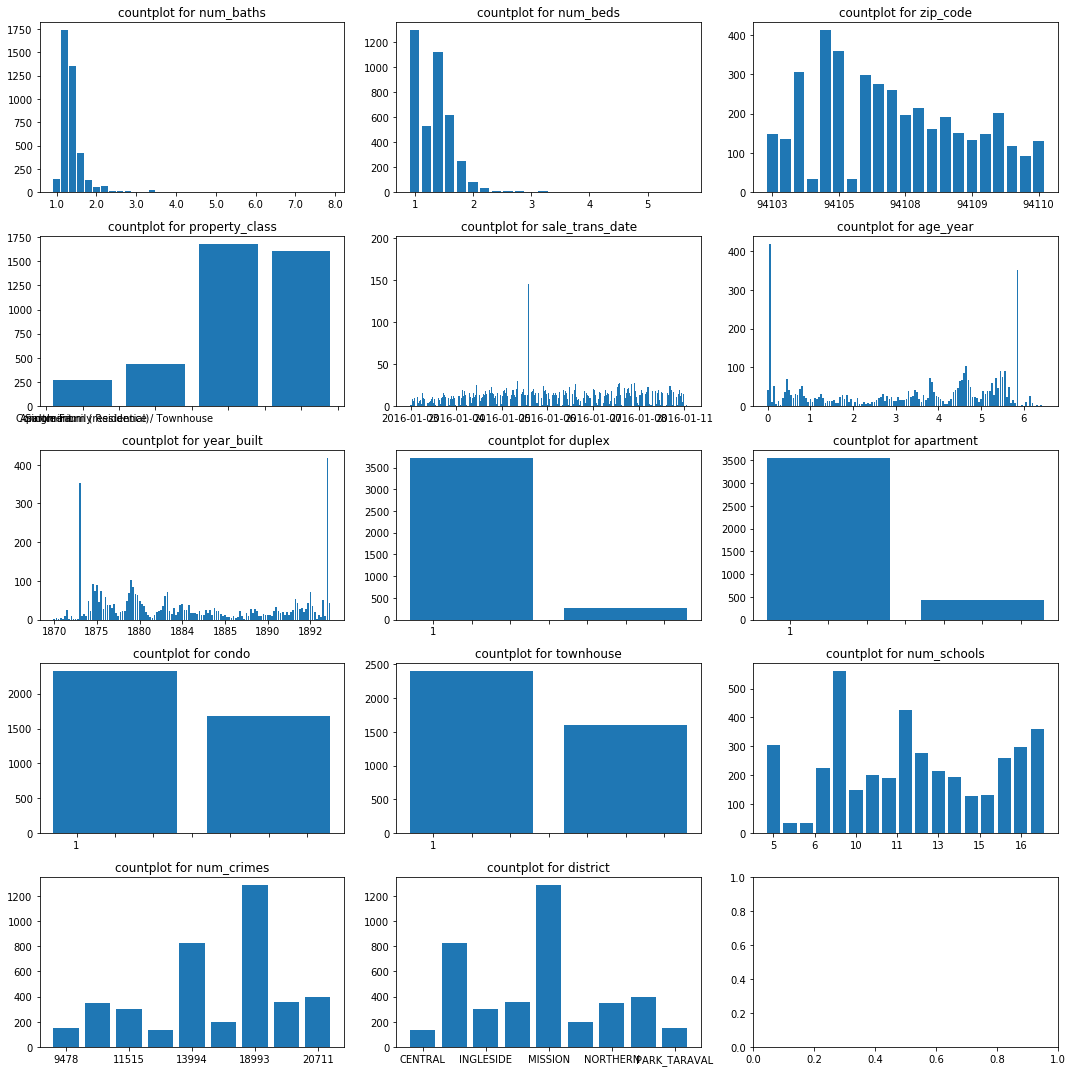

In [72]:
# plot categorical/discrete numeric cols
num_cat = len(cat_cols)
ncols = 3
nrows = math.ceil(num_cat/ncols)
cat_fig, cat_axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols):
        ax = cat_axes[row][col]
        idx = ncols * row + col
        if idx < num_cat:
            counts = init_df[cat_cols[idx]].value_counts().sort_index()
            ind = np.arange(len(counts))
            ax.bar(ind, counts.values)
            ax.set_xticklabels(counts.index.values)
            ax.set_title('countplot for {}'.format(cat_cols[idx]))
plt.tight_layout()

#### Findings from the countplots above. Analysis see below

Q1. age_year might have values of 0?  
Q2. age_year and year_built are duplicates?  
Q3. a property can be duplex, apartment, condo... at the same time?  
Q4: correlation between num_baths & num_beds?

**Q1**

In [73]:
# age_year
init_df.age_year.value_counts().sort_index().head()

-1     42
 0    418
 1     10
 2     51
 3      6
Name: age_year, dtype: int64

In [74]:
# why age_year = -1?
init_df[init_df['age_year']==-1].year_built.values

array([2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017,
       2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017,
       2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017,
       2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017])

**=> Answer to Q1: Consider to remove the properties built in 2017**

**Q2**

In [75]:
year_df = init_df[['age_year', 'year_built']]
year_df['calc_age'] = 2016 - year_df['year_built']
year_df['same'] = np.where(year_df['age_year']==year_df['calc_age'], 1, 0)
year_df['same'].value_counts()

1    3997
Name: same, dtype: int64

**=> Answer to Q2:**  
 - **verified: age_year = (2017 - year_built)**    
 - **consider to remove year_built and keep age_year only**

**Q3**

In [76]:
class_df = init_df[['duplex', 'apartment', 'condo', 'townhouse']]
class_df['sum'] = class_df['duplex'] + class_df['apartment'] + class_df['condo'] + class_df['townhouse']
class_df['sum'].value_counts()

1    3997
Name: sum, dtype: int64

**=> Answer to Q3: a property is either duplex or apartment or condo or townhouse**

**Q4**

Text(0,0.5,'num_beds')

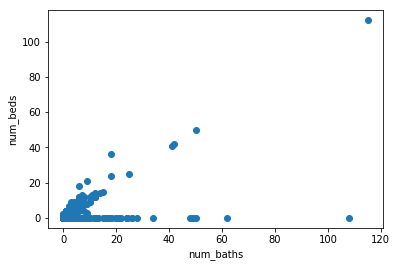

In [77]:
plt.scatter(x=init_df['num_baths'], y=init_df['num_beds'])
plt.xlabel('num_baths')
plt.ylabel('num_beds')

**=> Answer to Q4: no significant correlation between num_baths and num_beds**

### 3.1.2 Continuous numeric columns

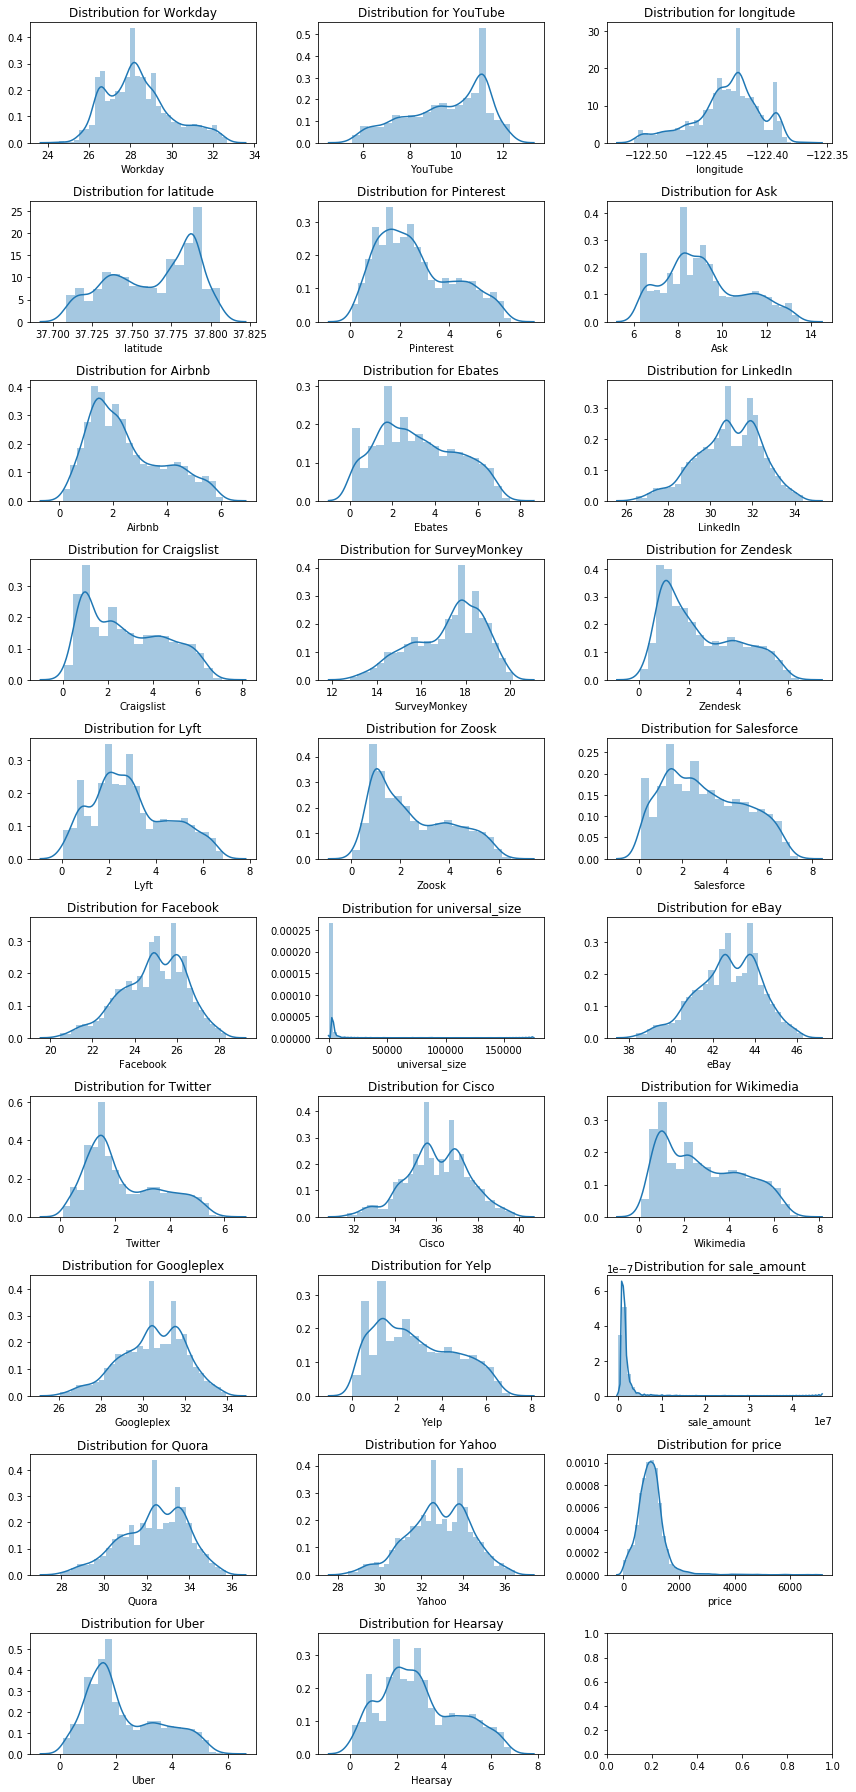

In [78]:
def draw_numeric_plot(init_df, numeric_col,figsize):
    num_numeric = len(numeric_cols)
    ncols = 3
    nrows = math.ceil(num_numeric/ncols)
    numeric_fig, numeric_axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    for row in range(nrows):
        for col in range(ncols):
            ax = numeric_axes[row][col]
            idx = ncols * row + col
            if idx < num_numeric:
                g=sns.distplot(init_df[numeric_cols[idx]], kde=True, label='skewness:%.2f' %
                     init_df[numeric_cols[idx]].skew(), ax = numeric_axes[row][col])
                plt.legend(loc='best', fontsize='large')
    #             ax.hist(init_df[numeric_cols[idx]])
                ax.set_title('Distribution for {}'.format(numeric_cols[idx]))
    plt.tight_layout()

draw_numeric_plot(init_df,numeric_cols,(12,25))

#### Findings from the histograms above. Analysis see below

Q1: price * universal_size = sale_amount?  
Q2: correlation between price & sale_amount, and universal_size & sale_amount?  
Q3: correlation between price & sum distance to all companies?

**Q1**

In [79]:
price_df = init_df[['price', 'universal_size', 'sale_amount']]
price_df['calc_amount'] = price_df['price'] * price_df['universal_size']
# if gap > $10, considered different
price_df['gap_is_small'] = np.where(abs(price_df['calc_amount'] - price_df['sale_amount'])>10, 0, 1)
price_df['gap_is_small'].value_counts()

1    3997
Name: gap_is_small, dtype: int64

**=> Answer to Q1: (price * universal_size) roughly equals to sale_amount, so consider to remove sale_amount**

**Q2**

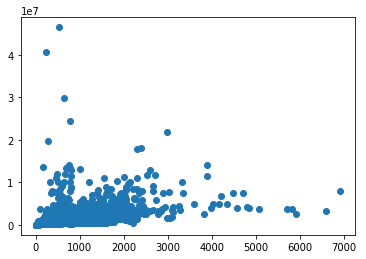

In [80]:
plt.scatter(x=price_df['price'], y=price_df['sale_amount'])

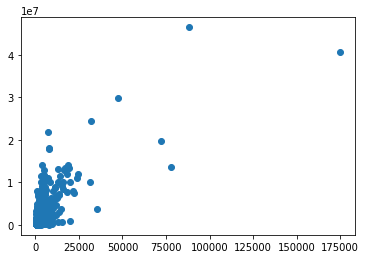

In [81]:
plt.scatter(x=price_df['universal_size'], y=price_df['sale_amount'])

**=> Answer to Q2: no significant correlation between price & sale_amount or universal_size & sale_amount**

**Q3**

In [82]:
company_names = set(numeric_cols).difference(set(['latitude', 'longitude', 'price', 
                                                  'universal_size', 'sale_amount']))
sum_dist = pd.Series(np.zeros(init_df.shape[0]))
for name in company_names:
    sum_dist += init_df[name]

dist_price_df = pd.concat([price_df, sum_dist], axis=1).rename(columns={0:"sum_dist"})
dist_price_df.head()

,price,universal_size,sale_amount,calc_amount,gap_is_small,sum_dist
0,746.728253,1299,970000,970000.0,1,325.956399
1,1093.355761,1189,1300000,1300000.0,1,298.417298
2,1036.542516,1423,1475000,1475000.0,1,324.903767
3,922.266140,1518,1400000,1400000.0,1,314.673066
4,924.491772,1033,955000,955000.0,1,404.389823


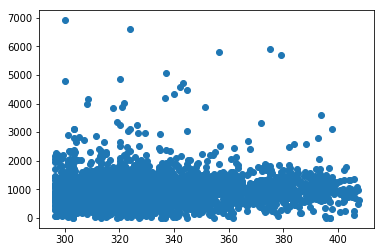

In [83]:
plt.scatter(x=dist_price_df['sum_dist'], y=dist_price_df['price'])

**=> Answer to Q3: no significant correlation between price & sum distance**

### 3.2 Summary of EDA, Get Clean Data Based On Exploration

1. remove properties built in 2017
2. use `price` as the label, drop `sale_amount`
3. drop `year_built`, keep `age_year`
4. drop `sale_trans_date`
5. calculate weighted average distance all companies, and drop distances to any individual company

In [84]:
# remove properties built in 2017
df_2016 = init_df[init_df['year_built']!=2017]
df_2016.shape

(3955, 43)

In [85]:
# calcultate weighted average distance
df_2016['wei_avg_dist'] = sum_dist
df_2016.head()

,num_baths,num_beds,latitude,longitude,zip_code,property_class,sale_trans_date,sale_amount,universal_size,year_built,...,Uber,Wikimedia,Workday,Yahoo,Yelp,YouTube,Zendesk,Zoosk,Facebook,wei_avg_dist
0,0.0,0,37.804640,-122.405206,94111,Condominium (residential),2016-01-04,970000,1299,1993,...,2.119180,1.072680,27.512888,33.919507,1.274629,12.252848,1.616944,1.561410,26.244291,325.956399
1,1.0,1,37.797958,-122.399894,94111,Condominium (residential),2016-01-29,1300000,1189,2007,...,1.601478,0.977182,26.252726,32.066999,0.722828,10.719006,1.161564,1.117405,24.363702,298.417298
2,2.0,0,37.803797,-122.404136,94111,Condominium (residential),2016-03-08,1475000,1423,1983,...,1.559842,1.016407,28.069057,34.010578,1.271120,11.765422,1.220212,1.192896,26.247054,324.903767
3,2.0,0,37.803797,-122.404136,94111,Condominium (residential),2016-03-21,1400000,1518,1983,...,0.462991,1.618165,28.143432,33.054255,1.673459,10.108376,0.996814,1.063310,25.155061,314.673066
4,0.0,0,37.804640,-122.405206,94111,Condominium (residential),2016-03-03,955000,1033,1993,...,4.866497,5.716206,32.523419,36.314220,5.882059,11.255354,5.278324,5.329572,28.177928,404.389823


In [86]:
# drop columns
dropped_cols = list(company_names) + ['sale_amount', 'year_built', 'latitude', 'longitude',
                                     'zip_code', 'district','property_class','sale_trans_date']
clean_df = df_2016.drop(dropped_cols, axis=1)
clean_df.head()

,num_baths,num_beds,universal_size,age_year,price,duplex,apartment,condo,townhouse,num_schools,num_crimes,wei_avg_dist
0,0.0,0,1299,23,746.728253,0,0,1,0,5,21040,325.956399
1,1.0,1,1189,9,1093.355761,0,0,1,0,5,21040,298.417298
2,2.0,0,1423,33,1036.542516,0,0,1,0,5,21040,324.903767
3,2.0,0,1518,33,922.266140,0,0,1,0,5,21040,314.673066
4,0.0,0,1033,23,924.491772,0,0,1,0,5,21040,404.389823


After calculating the weighted distance from company to house, let's look at the relationship between weighted distance and price.

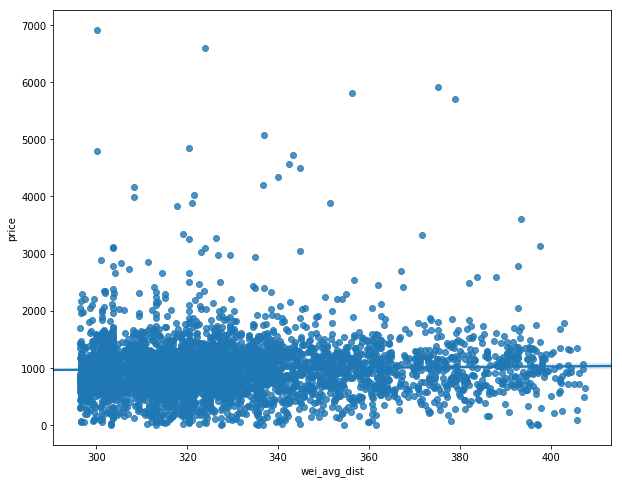

In [87]:
plt.subplots(figsize=(10, 8))  # 设置图形大小
sns.regplot(x=clean_df['wei_avg_dist'], y=clean_df['price'])  # corr()函数计算关联系数，并绘图

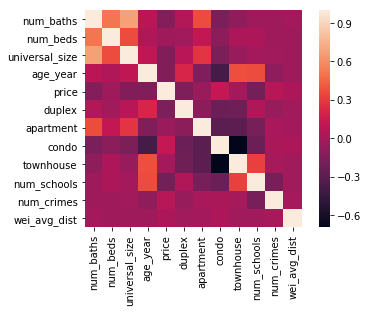

In [88]:
sns.heatmap(clean_df.corr(),square=True)

## 4. Feature Engineering

**Use `clean_df` for the feature engineering**

Thoughts:
1. skewed numeric data -> log transformation, normalization
2. change data type -> numeric data & category data
3. Remove outliers


- Check data type

In [89]:
clean_df.dtypes

num_baths         float64
num_beds            int64
universal_size      int64
age_year            int64
price             float64
duplex              int64
apartment           int64
condo               int64
townhouse           int64
num_schools         int64
num_crimes          int64
wei_avg_dist      float64
dtype: object

In [90]:
def type_transformation(data, dtype):
    """Input:
        data (dataframe): data column that needs to be transformed
        dtype (str): target data type
    """
    for col in data.columns:
        data[col] = data[col].astype(dtype)
    return data

clean_df[['duplex','apartment','condo','townhouse']] = type_transformation(clean_df[['duplex','apartment','condo','townhouse']],'category')

In [91]:
numeric_cols = [x for x in clean_df.columns if clean_df[x].dtypes in ['float64','int64']]
numeric_cols

['num_baths',
 'num_beds',
 'universal_size',
 'age_year',
 'price',
 'num_schools',
 'num_crimes',
 'wei_avg_dist']

In [92]:
# category columns
cat_cols = ['duplex','apartment','condo','townhouse']

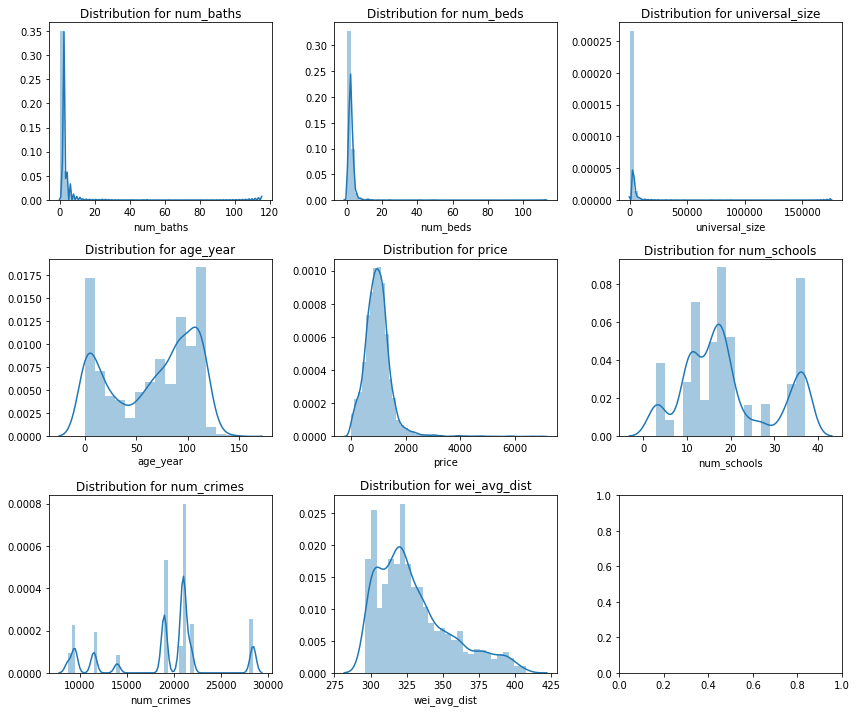

In [93]:
draw_numeric_plot(clean_df,numeric_cols,(12,10))

### 4.1 Outliers

Remove outliers in `num_baths`, `num_beds` and `universal_size`. Set the `95%` quartile as our threshold

In [94]:
describe_baths = clean_df['num_baths'].describe(percentiles=[0.01,0.05,.95,.99])
describe_beds = clean_df['num_beds'].describe(percentiles=[0.01,0.05,.95,.99])
describe_size = clean_df['universal_size'].describe(percentiles=[0.01,0.05,.95,.99])

threshold_baths = describe_baths['95%']
threshold_beds = describe_beds['95%']
threshold_size = describe_size['95%']

clean_df = clean_df.loc[clean_df['num_baths'] <= threshold_baths]
clean_df = clean_df.loc[clean_df['num_beds'] <= threshold_beds]
clean_df = clean_df.loc[clean_df['universal_size'] <= threshold_size]

print("95% num_baths less than:", threshold_baths)
print("95% num_beds less than:", threshold_beds)
print("95% universal_size less than:", threshold_size)

95% num_baths less than: 5.0
95% num_beds less than: 4.0
95% universal_size less than: 4364.4


In [95]:
print('# samples: %d' % len(clean_df))

# samples: 3619


- Numeric transformation using `log` transformation or `boxcox` transformation

In [96]:
def numeric_normalization(data,method,lam=0.1):
    """
    Input:
        data (dataframe): input dataframe
        lam (float): lambda value for box-cox transformation
        methoe (str): method of numeric transformation
    Output:
        data (dataframe): return a dataframe with tranformed numeric data
    """
    if method == 'log':
        data = np.log((data+0.1)) # a trick to avoid zero value which will crash np.log()
    if method == 'boxcox':
        data = boxcox1p(data,lam)
    return data

In [97]:
clean_df[numeric_cols] = numeric_normalization(clean_df[numeric_cols], 'log')

In [98]:
# check skewness of each numeric data
print(clean_df[numeric_cols].skew())

num_baths        -2.146317
num_beds         -0.627751
universal_size    0.047503
age_year         -1.805834
price            -3.603761
num_schools      -0.960931
num_crimes       -0.988499
wei_avg_dist      0.804919
dtype: float64


- Normalize numeric data into range (0,1)

In [99]:
# def normalization(data):
#     return data/np.sum(data,axis=0)

In [100]:
clean_df.head()

,num_baths,num_beds,universal_size,age_year,price,duplex,apartment,condo,townhouse,num_schools,num_crimes,wei_avg_dist
0,-2.302585,-2.302585,7.169427,3.139833,6.615835,0,0,1,0,1.629241,9.954185,5.787070
1,0.095310,0.095310,7.080952,2.208274,6.997098,0,0,1,0,1.629241,9.954185,5.698828
2,0.741937,-2.302585,7.260593,3.499533,6.943742,0,0,1,0,1.629241,9.954185,5.783837
3,0.741937,-2.302585,7.325215,3.499533,6.826942,0,0,1,0,1.629241,9.954185,5.751852
4,-2.302585,-2.302585,6.940319,3.139833,6.829352,0,0,1,0,1.629241,9.954185,6.002627


In [101]:
y = clean_df['price']
X = clean_df.drop(['price'],axis=1)

In [102]:
numeric_cols.remove('price')
min_max_scaler = preprocessing.MinMaxScaler()
X[numeric_cols] = min_max_scaler.fit_transform(X[numeric_cols])

In [103]:
print(X.head())

   num_baths  num_beds  universal_size  age_year duplex apartment condo  \
0   0.000000  0.000000        0.604428  0.746181      0         0     1   
1   0.609868  0.645711        0.575534  0.618460      0         0     1   
2   0.774328  0.000000        0.634200  0.795498      0         0     1   
3   0.774328  0.000000        0.655304  0.795498      0         0     1   
4   0.000000  0.000000        0.529607  0.746181      0         0     1   

  townhouse  num_schools  num_crimes  wei_avg_dist  
0         0     0.200562     0.74446      0.299215  
1         0     0.200562     0.74446      0.022393  
2         0     0.200562     0.74446      0.289071  
3         0     0.200562     0.74446      0.188733  
4         0     0.200562     0.74446      0.975430  


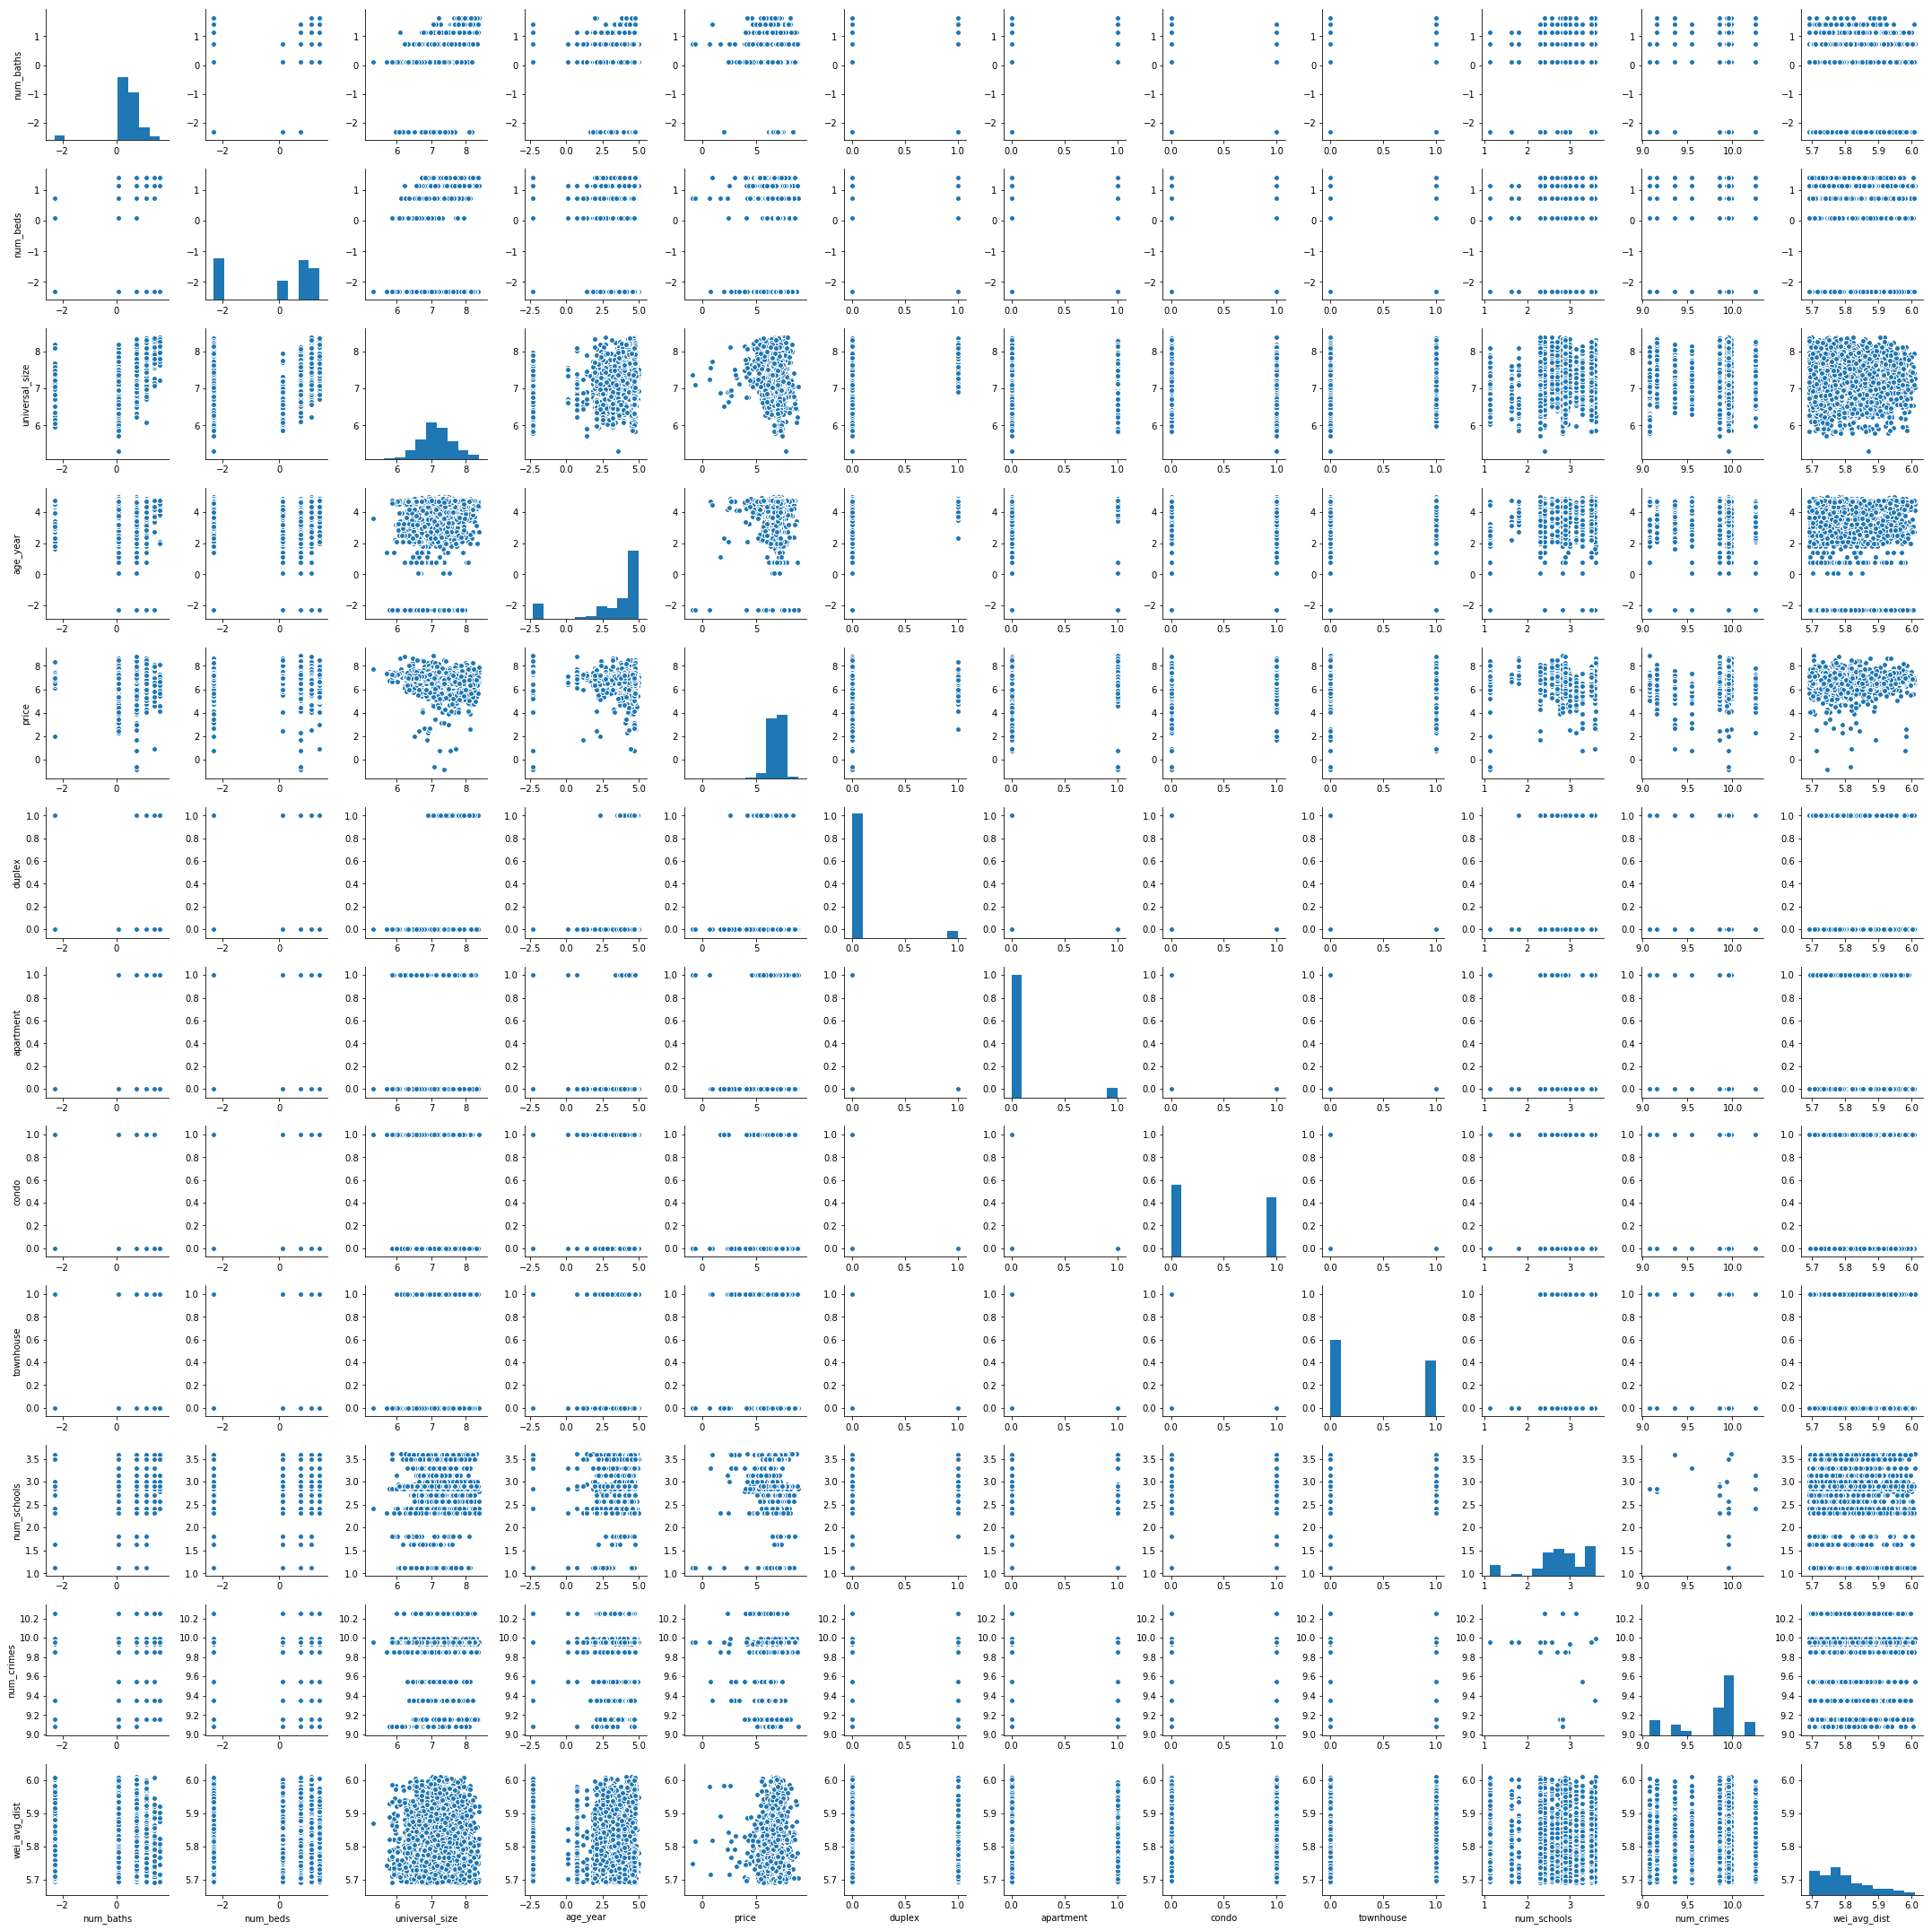

In [104]:
ax = sns.pairplot(clean_df)

In [105]:
print('Toal number of features：%d' % X.shape[1])    

Toal number of features：11


## 5. Models
1. Split data
2. Calculate baseline
2. Tried several models and see if the train data can be fit into a proper model.
3. Pick a certain model and use grid search to find good combinations of hyper parameters.

### 5.1 Split data into training set and test set

In [106]:
# try to exclude some columns
X_try = X.drop('wei_avg_dist', axis=1)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X_try, y, test_size=0.33, random_state=7)

### 5.2 Baseline

In [108]:
# Calculate mean squared error on both the training and validation set
def compute_mse(model, X, y):
    """ Given a linear regression model, calculate the mean squared error for the 
        training dataset, the validation dataset, and for a mean prediction
        Args:
            model (LR_model) : Linear model
            X (array-like) : feature matrix of training data where each row corresponds to an example
            y (array like) : vector of training data outputs 
        Return: 
            MSE of linear regression on the data set    
    """
    y_pred = model.predict(X)
    train_mse = np.mean(np.power(y_pred-y,2))
    return train_mse

In [110]:
# baseline for training data
mean_y_train = y_train.mean()
train_mse_base = np.mean(np.power(mean_y_train - y_train,2))
print("baseline MSE for training data:", train_mse_base)

# baseline for test data
mean_y_test = y_test.mean()
test_mse_base = np.mean(np.power(mean_y_test - y_test,2))
print("baseline MSE for test data:", test_mse_base)

baseline MSE for training data: 0.3601757217582955
baseline MSE for test data: 0.39244650332022646


### 5.3 Modeling

### 5.3.1 Lasso 
**Lasso Linear Regression:**
In order to avoid overfitting, choose Linear Model trained with L1 prior as regularizer -> `lasso` linear model to run regression.   
Use `Learning Curve` to check our regression model.

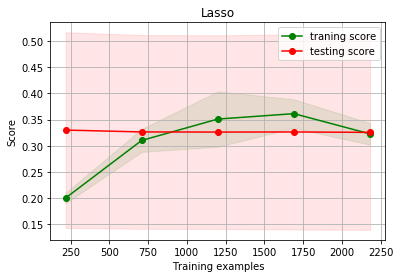

In [111]:
def plot_learning_curve(estimator, title, X, y, cv = 10, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)  
    plt.xlabel('Training examples') 
    plt.ylabel('Score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring="neg_mean_squared_error",
                                                            train_sizes=train_sizes)
    train_scores_mean = np.mean(-train_scores, axis=1) 
    train_scores_std = np.std(-train_scores, axis=1) 
    test_scores_mean = np.mean(-test_scores, axis=1) 
    test_scores_std = np.std(-test_scores, axis=1) 
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1, color='g') 
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1, color='r') 
    plt.plot(train_sizes, train_scores_mean, 'o-', color='g',
             label='traning score') 
    plt.plot(train_sizes, test_scores_mean, 'o-', color='r',
             label='testing score') 
    plt.legend(loc='best')
    return plt

clf = Lasso(alpha=0.0005)
g = plot_learning_curve(clf, 'Lasso', X_train, y_train)  # 调用 plot_learning_curve 绘制学习曲线

In [113]:
clf.fit(X_train, y_train)
lasso_train_mse = compute_mse(clf, X_train, y_train)
lasso_test_mse = compute_mse(clf, X_test, y_test)
print("Lasso MSE for training data:", lasso_train_mse)
print("Lasso MSE for test data:", lasso_test_mse)

Lasso MSE for training data: 0.3228652668695259
Lasso MSE for test data: 0.3606628415561485


### 5.3.2 Linear Regression

In [114]:
from sklearn.linear_model import LinearRegression
gs = LinearRegression()
gs.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [115]:
lr_train_mse = compute_mse(gs, X_train, y_train)
lr_test_mse = compute_mse(gs, X_test, y_test)
print("LR MSE for training data:", lr_train_mse)
print("LR MSE for test data:", lr_test_mse)

LR MSE for training data: 0.32281131993834894
LR MSE for test data: 0.3611164597311545


### 5.3.3 Polynomial

In [119]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

clf_poly = linear_model.LinearRegression()
clf_poly.fit(X_train_poly, y_train)

clf_poly_train_mse = compute_mse(clf_poly, X_train_poly, y_train)
clf_poly_test_mse = compute_mse(clf_poly, X_test_poly, y_test)
print("Poly MSE for training data:", clf_poly_train_mse)
print("Poly MSE for test data:", clf_poly_test_mse)

Poly MSE for training data: 0.2836921550242113
Poly MSE for test data: 0.33135539307700124


### 5.3.4 RandomForests

In [116]:
from sklearn.ensemble import RandomForestRegressor
rf0 = RandomForestRegressor() #oob_score=True
rf0.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [117]:
rf0_train_mse = compute_mse(rf0, X_train, y_train)
rf0_test_mse = compute_mse(rf0, X_test, y_test)
print("RF MSE for training data:", rf0_train_mse)
print("RF MSE for test data:", rf0_test_mse)

RF MSE for training data: 0.08366993207448231
RF MSE for test data: 0.3550118146274987


### 5.3.5 Grid search

#### Choose number of estimators
We are using log2 as max features so as to avoid overfitting.

In [134]:
from sklearn.model_selection import GridSearchCV
param_test1= {'n_estimators':range(5,151,10)} 
gsearch1= GridSearchCV(estimator = RandomForestRegressor(max_features='log2'),  
                       param_grid =param_test1, cv=10)  
gsearch1.fit(X_train,y_train)  
gsearch1.grid_scores_,gsearch1.best_params_, gsearch1.best_score_  


([mean: 0.15540, std: 0.12800, params: {'n_estimators': 5},
  mean: 0.19938, std: 0.11066, params: {'n_estimators': 15},
  mean: 0.23861, std: 0.06989, params: {'n_estimators': 25},
  mean: 0.25892, std: 0.09343, params: {'n_estimators': 35},
  mean: 0.24901, std: 0.08395, params: {'n_estimators': 45},
  mean: 0.25217, std: 0.08039, params: {'n_estimators': 55},
  mean: 0.25561, std: 0.07420, params: {'n_estimators': 65},
  mean: 0.25944, std: 0.07894, params: {'n_estimators': 75},
  mean: 0.27174, std: 0.08125, params: {'n_estimators': 85},
  mean: 0.25290, std: 0.08412, params: {'n_estimators': 95},
  mean: 0.25595, std: 0.07816, params: {'n_estimators': 105},
  mean: 0.25587, std: 0.09220, params: {'n_estimators': 115},
  mean: 0.26029, std: 0.08314, params: {'n_estimators': 125},
  mean: 0.25300, std: 0.08331, params: {'n_estimators': 135},
  mean: 0.26156, std: 0.08921, params: {'n_estimators': 145}],
 {'n_estimators': 85},
 0.27173928585579671)

We will choose 85 as the number of estimators.

#### Choose number of estimators
We are using log2 as max features so as to avoid overfitting.

In [145]:
rflog2 = RandomForestRegressor(n_estimators=85, max_features='log2') #oob_score=True
rflog2.fit(X_train, y_train)
rflog2_train_mse = compute_mse(rflog2, X_train, y_train)
rflog2_test_mse = compute_mse(rflog2, X_test, y_test)
print("RF MSE for training data:", rflog2_train_mse)
print("RF MSE for test data:", rflog2_test_mse)

RF MSE for training data: 0.07440827617363982
RF MSE for test data: 0.3195715377297734


In [144]:
rfsqrt = RandomForestRegressor(n_estimators=85, max_features='sqrt') #oob_score=True
rfsqrt.fit(X_train, y_train)
rfsqrt_train_mse = compute_mse(rfsqrt, X_train, y_train)
rfsqrt_test_mse = compute_mse(rfsqrt, X_test, y_test)
print("RF MSE for training data:", rfsqrt_train_mse)
print("RF MSE for test data:", rfsqrt_test_mse)

RF MSE for training data: 0.07253831100451706
RF MSE for test data: 0.31916263975676834


In this case, we will use sqrt(n) (n being the number of all features) as the maximum feature number.